## Spatial Scaling Factor
- Generates figures for spatial $x>95$ scaling factor, and subsequent analysis. Includes zonal average and lat/lon grid.
- This requires the `REFHT_quant95` job to have been run on JASMIN [🔗](https://github.com/jduffield65/Isca/blob/main/jobs/cesm/3_hour/hottest_quant/pre_industrial/REFHT_quant95/input.nml)
- Datasets used in this script are saved as `./ds_processed/all_ds_coarse_av_quant95.nc`.
- To generate the convective fraction figure, need to run with `load_from_file=False`.

In [1]:
import xarray as xr
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from tqdm.notebook import tqdm
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
from matplotlib.offsetbox import TextArea, HPacker, AnnotationBbox

from isca_tools.cesm import get_pressure
from isca_tools.convection.base import lcl_sigma_bolton_simple
import cartopy.crs as ccrs

from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry, temp_kelvin_to_celsius
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel, get_scale_factor_theory_numerical2, \
    get_scale_factor_theory, get_sensitivity_factors
from isca_tools.thesis.adiabat_theory2 import get_cape_approx
from isca_tools.utils.decomposition import scaled_k_means_single
from isca_tools.utils.ds_slicing import fold_coarsen
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.xarray import wrap_with_apply_ufunc, isel_float
import jobs.theory_lapse.cesm.thesis_figs.scripts.utils as utils
from xarray_einstats.stats import circmean as xr_circmean
from datatree import DataTree, open_datatree

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']
leg_handlelength = 1.5

In [3]:
out_path = os.path.join(utils.out_dir, "all_ds_coarse_av_quant95.nc")
load_from_file = True       # TO create all figures and get all stats, run with False but longer.
if load_from_file:
    ds_all = open_datatree(out_path)
    ds_av_global = ds_all['ds_av_global'].ds.load()
    ds_lat = ds_all['ds_lat'].ds.load()
    ds_spatial = ds_all['ds_spatial'].ds.load()
    mask_loc = ds_all['mask_loc'].ds.mask_loc.load()
    print(f'Loaded datasets from {out_path}')

Loaded datasets from /Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse/cesm/thesis_figs/ds_processed/all_ds_coarse_av_quant95.nc


## Load data and average over `lon_sample` dimension
We average over all days for which the convective threshold is satisfied.

For `ds_ref` quantities, we average over all convective days. For `ds_quant`, we average over all convective days separately for each temperature quantile, $x$. The variables $\chi[x]$ conditioned on $x$, are then computed from these variables, as was done in the previous scaling factor theory.

In [4]:
%%time
if not load_from_file:
    ds = []
    with tqdm(total=len(utils.exp_names), position=0, leave=True) as pbar:
        for exp_name in utils.exp_names:
            ds.append(utils.load_ds(exp_name, 95,
                                    var_keep=utils.vars_lapse_data + ['SOLIN', 'time', 'FREQZM', 'time']).load())
            pbar.update(1)
    ds = xr.concat(ds, dim=xr.DataArray([utils.get_co2_multiplier(utils.exp_names[i])
                                         for i in range(len(ds))], dims="co2", name='co2'))
    # ds = ds.sel(lat=slice(-45, 75))  # ignore antarctica and north pole
    # ds['albedo'] = 1 - ds.FSNS / ds.FSDS
    # Get time in UTC of midday at every longitude
    time_peak_insolation = (ds.time.dt.hour.mean(dim='sample').isel(co2=0) * 0 + (12 - ds.lon / 15) % 24)
    # Given the time in UTC at every coordinate and sample (ds.time), compute time compared to local midday in range [-12, 12]
    ds['time_from_midday'] = ((ds.time.dt.hour - time_peak_insolation+12)%24-12)
    ds['dayofyear'] = ds.time.dt.dayofyear
    # ds = ds.drop_vars(['time', 'FSDS', 'FSNS'])
    # Only keep land coords
    from jobs.theory_lapse.cesm.thesis_figs.scripts.load_ds_tropics import land_frac_thresh

    lsm = ds.LANDFRAC.isel(co2=0) > land_frac_thresh
    ocean_mask = ds.LANDFRAC.isel(co2=0) == 0

    # Chose best rh_mod
    ds = utils.sel_best_rh_mod(ds)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 1.91 µs


In [5]:
# Duan 2024b analysis
# Rn = ds.SHFLX +  ds.LHFLX
# sens_factor = (ds.SHFLX / Rn).where(ds.SHFLX>0)                  # 1/psi term, only use days where SHFLX positive to avoid blowing up
# sens_factor.mean(dim='sample').where(lsm).isel(co2=0).plot(vmax=1)
# Rn.mean(dim='sample').where(lsm).diff(dim='co2').plot()

# Net energy into surface eqn
# var = (ds.FSNS.mean(dim='sample') - ds.SHFLX.mean(dim='sample')-ds.LHFLX.mean(dim='sample')-ds.FLNS.mean(dim='sample')
#  ).where(lsm)

# Hour change fig - either 7 hours after midday or before midday
# ((ds['time_from_midday']>7) | (ds['time_from_midday']<0)).sum(dim='sample').diff(dim='co2').where(lsm).plot()

## Which $p_{FT}$ to choose
Here, 400hPa is better because more *convective* days according to error thresholding, and helps with topography issues i.e. more
regions have at least 100hPa from LCL to FT level.

I plot the difference in number of convective days between 400hPa and 500hPa, and get more (red) especially in tropics for 400hPa.

In [6]:
# get rid of nan - due to different amounts of land at each lat
if not load_from_file:
    print('Total number of convective days')
    n_days = (~np.isnan(ds.TREFHT.where(lsm))).sum(dim=['lat', 'lon', 'sample']).values
    for p_ft in ds.p_ft:
        var1 = utils.get_valid_mask(ds.sel(p_ft=p_ft), aloft_p_size_thresh=0).where(lsm).sum(
            dim=['lat', 'lon', 'sample']).values / n_days * 100
        var2 = utils.get_valid_mask(ds.sel(p_ft=p_ft)).where(lsm).sum(dim=['lat', 'lon', 'sample']).values / n_days * 100
        print(int(p_ft / 100), 'No lcl masking', np.round(var1, 1), 'With lcl masking', np.round(var2, 1))
else:
    print('To get number of convective days for different p_ft, need to use load_from_file=False')

To get number of convective days for different p_ft, need to use load_from_file=False


In [7]:
if not load_from_file:
    co2_plot_ind = 0
    fig, ax = plt.subplots(1, 1)
    fig_resize(fig, width['one_col'])
    var = [utils.get_valid_mask(ds.sel(p_ft=p_ft)).where(lsm).sum(dim='sample').isel(co2=co2_plot_ind) /
           (~np.isnan(ds.TREFHT)).where(lsm).sum(dim='sample').isel(co2=co2_plot_ind) * 100 for p_ft in ds.p_ft]
    (var[0] - var[1]).where(lsm).plot(ax=ax)
    update_fontsize(fig)
    plt.show()

In [8]:
%%time
if not load_from_file:
    p_ft_use = 400 * 100
    ds = ds.sel(p_ft=p_ft_use)
    ds['p_lnb_approx'] = get_pressure(ds.PS, ds.P0, ds.hyam, ds.hybm).isel(
        lev=ds.lnb1_ind)
    ds['lapse_Dz'] = ds.mod_parcel_lapse.isel(layer=0) / 1000 - lapse_dry
    ds['lapse_Mz'] = ds.mod_parcel_lapse.isel(layer=1) / 1000
    ds['lapse_D'] = R / g * ds.TREFHT * ds['lapse_Dz']
    ds['lapse_M'] = R / g * ds.T_ft_env * ds['lapse_Mz']
    lat_weights = utils.lat_weights.reindex_like(ds.lat)
    temp_surf_lcl_calc = ds.temp_surf_lcl_calc
    p_ft = float(ds.p_ft)

    # Get rid of variables no longer need. Must remove those without lon, lat, sample in dimensions for fold_coarsen to work
    drop_vars = ['hyam', 'hybm', 'lnb1_ind', 'LANDFRAC', 'const_lapse', 'mod_parcel_lapse']
    ds = ds.drop_vars(drop_vars)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.15 µs


In [9]:
if not load_from_file:
    # FT anomaly from zonal mean on that day
    temp_ft_zm = xr.concat([xr.load_dataset(os.path.join(utils.out_dir, f"ds_t400_climatology_{exp_name}.nc"))
                            for exp_name in utils.exp_names], dim=ds.co2).T.sel(plev=p_ft_use, drop=True)
    ds['T_ft_env_zm'] = temp_ft_zm.sel(dayofyear=ds.time.dt.dayofyear).drop_vars('dayofyear')
    ds['T_ft_env_anom'] = ds.T_ft_env - ds['T_ft_env_zm']
    ds = ds.drop_vars('time')
else:
    temp_ft_zm = xr.concat([xr.load_dataset(os.path.join(utils.out_dir, f"ds_t400_climatology_{exp_name}.nc"))
                            for exp_name in utils.exp_names], dim=ds_lat.co2).T.sel(plev=ds_lat.p_ft, drop=True)

## Sanity check for convective definition
Below I compare % of days where convection scheme triggered (b) with % of days classified as convective in our regime.

Also, use to say only consider land as ocean no real convection outside tropics.

In [10]:
if not load_from_file:
    # Also avoid regions below freezing
    ds['mask_conv'] = utils.get_valid_mask(ds) & (ds.TREFHT > temp_kelvin_to_celsius)
    ds['lsm'] = (ds.TREFHT > 0).isel(co2=0) & lsm  # so lsm has sample dimension required for coarsening
    ds['lat_weights'] = lat_weights.where((ds.TREFHT > 0).isel(co2=0))

In [11]:
def plot_scatter_mask(mask, ax, s=12, color='k', marker='.', zorder=20, edgecolors='None', linewidths=1.0):
    # Cyclic versions of BOTH data and mask along lon axis=1
    mask_c, lon_c = add_cyclic_point(mask.values.astype(int), coord=mask["lon"].values, axis=1)  # [web:66]
    mask_c = mask_c.astype(bool)

    # Scatter where True (now indices match lon_c)
    iy, ix = np.where(mask_c)

    lon_pts = lon_c[ix]
    lat_pts = mask["lat"].values[iy]

    return ax.scatter(lon_pts, lat_pts, transform=ccrs.PlateCarree(),
                      s=s, marker=marker, facecolors=color, edgecolors=edgecolors, zorder=zorder, linewidths=linewidths)

## Coarsen Grid
Below, I coarsen grid, and then consider regions for which there are atleast 50 valid days at that new larger grid point.
There is still a significant number of regions to do subsequent analysis.

Do that here so in convection point can indicate locations included.

In [12]:
if not load_from_file:
    lat_min = -45
    lat_max = 75
    n_coarse_lat = 4
    n_coarse_lon = 4
    ds_coarse = fold_coarsen(ds.sel(lat=slice(lat_min, lat_max)), k_lat=n_coarse_lat, k_lon=n_coarse_lon)
    ds_coarse.attrs['n_coarse_lat'] = n_coarse_lat
    ds_coarse.attrs['n_coarse_lon'] = n_coarse_lon
    ds_coarse.attrs['lat_min'] = lat_min
    ds_coarse.attrs['lat_max'] = lat_max
    ds_coarse['mask_conv'] = ds_coarse['mask_conv'] & ds_coarse['lsm']  # only include land from now on
    ds_coarse.attrs['temp_surf_lcl_calc'] = temp_surf_lcl_calc
    ds_coarse.attrs['p_ft'] = float(ds.p_ft)
    # ds_coarse['lapse_D'] = ds_coarse['lapse_D'].clip(min=-100)
    ds_coarse['rh_mod'] = ds.rh_mod[ds_coarse.mod_parcel_rh_mod_ind]
    ds_coarse.attrs['mask_loc_n_valid_thresh'] = 400          # atleast this many days at a grid point
    mask_loc_conv = (ds_coarse.mask_conv.sum(dim='sample') > ds_coarse.mask_loc_n_valid_thresh).all(dim='co2')  # choose where > 400 days

    # Clip lapse_D so no extreme values; some are really large - only affects high latitudes
    ds_coarse.attrs['thresh_lapse_D_clip'] = -20
    ds_coarse = ds_coarse.rename_vars({'lapse_D': 'lapse_D_no_clip'})           # keep original lapse_D values
    ds_coarse['lapse_D'] = ds_coarse['lapse_D_no_clip'].clip(min=ds_coarse.thresh_lapse_D_clip)     # Make default lapse_D the clipped values

In [13]:
if not load_from_file:
    thresh_residual_diff = 0.05  # mask out region where deviation in scaling factors more than this fraction
    temp_change_conv = ds_coarse.TREFHT.where(ds_coarse.mask_conv & mask_loc_conv).weighted(ds_coarse.lat_weights).mean(dim='sample').diff(dim='co2').squeeze()
    temp_change_all = ds_coarse.TREFHT.where(ds_coarse.lsm & mask_loc_conv
                                             ).weighted(ds_coarse.lat_weights).mean(dim='sample').diff(dim='co2').squeeze()
    mask_residual_diff = np.abs((temp_change_all-temp_change_conv)/temp_change_all)<thresh_residual_diff
    print("Number grid points removed due to mismatch of sf:", int((~mask_residual_diff).where(mask_loc_conv).sum().values))
    mask_loc = mask_loc_conv & mask_residual_diff

    # Print the percentile of total lapse_D that we clipped
    print(f"Percentile corresponding to lapse_D=-20: {(ds_coarse['lapse_D_no_clip'].where(mask_loc & ds_coarse.mask_conv) <= ds_coarse.thresh_lapse_D_clip).sum() / (mask_loc & ds_coarse.mask_conv).sum() * 100:.2f}%")
    print(f"Smallest value of lapse_D: {ds_coarse.lapse_D_no_clip.where(mask_loc & ds_coarse.mask_conv).min():.0f}K")
else:
    print('To get lapse_D statistics, need to set load_from_file=False')

To get lapse_D statistics, need to set load_from_file=False


In [14]:
# In moist regions get some really big lapse_D values.
# Set these to nan so don't include going foreward. Only remove in moist regions, because in dry boundary layer effect actually significant
# thresh_moist = 0.7
# thresh_lapse_D = ds_coarse.lapse_D.where(ds_coarse.mask_conv & mask_loc & (ds_coarse.rh_REFHT<thresh_moist)).quantile(0.01)
# mask_lapse_D_clip = ds_coarse.mask_conv & mask_loc & (ds_coarse.rh_REFHT>thresh_moist) & (ds_coarse.lapse_D<thresh_lapse_D)
# ds_coarse['lapse_D'] = xr.where(mask_lapse_D_clip, np.nan, ds_coarse['lapse_D'])
# ds_coarse['lapse_D'] = ds_coarse['lapse_D'].clip(min=-20)

In [15]:
if not load_from_file:
    # % of land days convective
    fig, ax = plt.subplots(1, 3)
    fig_resize(fig, 8)
    ((ds_coarse.mask_conv).sum(dim='sample') / (ds_coarse.lsm).sum(dim='sample')).isel(co2=0).plot(ax=ax[0])
    mask_loc_conv.plot(ax=ax[1])
    # Show regions where convective not representative
    (np.abs((temp_change_all-temp_change_conv)/temp_change_all)>thresh_residual_diff).where(mask_loc_conv).plot(ax=ax[2])
    plt.show()

In [16]:
gl_fontsize = 5.74
if load_from_file:
    print('To generate this figure of fraction of convective days and FREQZM>0 days at each grid point, need to set load_from_file=False')
else:
    var = [(ds['mask_conv'].sum(dim='sample') / ds.sample.size * 100).isel(co2=0),
           ((ds.FREQZM > 0).sum(dim='sample') / ds.sample.size * 100).isel(co2=0)]

    fig = plt.figure(constrained_layout=True)
    ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
    fig_resize(fig, 10, ar=8)
    for i, ax_use in enumerate(ax):
        gl = utils.initialize_ax_projection(ax_use, lat_min=-90, lat_max=90, grid_lat=[-30, 30], return_gl=True,
                                            coastline_lw=0.5, gridline_lw=0.5, grid_lon=[-180, -90, 0, 90, 180])[1]
        gl.xlabel_style = {"size": gl_fontsize}
        gl.ylabel_style = {"size": gl_fontsize}
        if i == 0:
            gl.bottom_labels = False
    contour_lev = np.linspace(0, 100, 11)
    for i in range(len(var)):
        im = utils.plot_contour_projection(ax[i], var[i], mask=None, imshow=True, imshow_kwargs={'vmin': 0, 'vmax': 100})
    plt.colorbar(im, ax=ax.ravel(), label='% of days', pad=0.02)

    # Add scatter plot showing regions excluded from subsequent analysis
    mask_use = (~mask_loc_conv) & (ds_coarse.lsm.sum(dim='sample') > ds_coarse.mask_loc_n_valid_thresh)
    plot_scatter_mask(mask_use, ax[0], color='w', marker='.', s=1)
    print(f"Number non-convective grid points = {int(mask_use.sum().values)}")
    mask_use = (np.abs((temp_change_all-temp_change_conv)/temp_change_all)>thresh_residual_diff).where(mask_loc_conv)
    plot_scatter_mask(mask_use, ax[0], color='w', marker='x', s=1, linewidths=0.1)
    print(f"Number deviant grid points = {int(mask_use.sum().values)}")

    print(f"Final grid has {int(mask_loc.sum())} coordinates | "
          f"{100*float(mask_loc.sum()/(ds_coarse.lsm.sum(dim='sample') > ds_coarse.mask_loc_n_valid_thresh).sum()):.1f}% of land")
    label_subplots(fig, ax, box_alpha=0, pos_y=-1)
    update_fontsize(fig)
    plt.show()
    # savefig(fig)

To generate this figure of fraction of convective days and FREQZM>0 days at each grid point, need to set load_from_file=False


In [17]:
# Plots about role of ice
# (ds_coarse.SOLIN).where(ds_coarse.mask_conv).mean(dim='sample').diff(dim='co2').where(mask_loc).plot()
# (ds_coarse.time_from_midday).where(ds_coarse.mask_conv).mean(dim='sample').diff(dim='co2').where(mask_loc).plot()
# (ds_coarse.TS - ds_coarse.TREFHT < 0).where(ds_coarse.mask_conv).sum(dim='sample').diff(dim='co2').where(mask_loc).plot()

## Scaling factor - Zonal Mean
Below I do the scaling factor analysis for the zonal mean.

In [18]:
if not load_from_file:
    ds_lat = ds_coarse.where(ds_coarse.mask_conv & mask_loc).weighted(ds_coarse.lat_weights).mean(dim=['lon', 'sample'])
    ds_lat.attrs = ds_coarse.attrs

    # Add all variables needed for notebook to ds_spatial so don't need ds_coarse
    ds_lat['n_valid'] = (ds_coarse.mask_conv & mask_loc).sum(dim=['lon', 'sample'])
    ds_lat['p_lnb_frac'] = (ds_coarse.p_lnb_approx.where(ds_coarse.mask_conv & mask_loc) < p_ft         # frac of days LNB above p_ft
                            ).sum(dim=['sample', 'lon']) / ds_lat.n_valid * 100
    ds_lat.attrs['lapse_miy2022_M_thresh'] = 13     # 13% threshold value for RCE comes from paper
    ds_lat['lapse_miy2022_frac_RCE'] = (ds_coarse.lapse_miy2022_M.where(ds_coarse.mask_conv & mask_loc) < ds_lat.lapse_miy2022_M_thresh).sum(
        dim=['sample', 'lon']) / ds_lat.n_valid * 100

    # Get fraction of days 7 hours after local midday or before local midday
    ds_lat.attrs['cold_hour_thresh_above'] = 7
    ds_lat.attrs['cold_hour_thresh_below'] = 0
    ds_lat['cold_hour_frac'] = ((ds_coarse.time_from_midday > ds_lat.cold_hour_thresh_above) | (
            ds_coarse.time_from_midday < ds_lat.cold_hour_thresh_below)
                                ).where(ds_coarse.mask_conv & mask_loc).sum(dim=['sample', 'lon']) / ds_lat.n_valid * 100



    av_no_extremes = True       # If True, will only use central quantiles to compute the global average
    ds_av_global = ds_coarse[
        ['PREFHT', 'rh_REFHT', 'TREFHT', 'lapse_D', 'lapse_M', 'T_ft_env', 'T_ft_env_zm', 'T_ft_env_anom', 'rh_mod']].where(
        ds_coarse.mask_conv & mask_loc).weighted(ds_coarse.lat_weights).mean(dim=['lon', 'sample', 'lat'])
    ds_av_global.attrs['av_no_extremes'] = str(av_no_extremes)
    if av_no_extremes:
        for key in ds_av_global:
            mask_no_extremes = (ds_coarse[key] >= ds_coarse[key].where(ds_coarse.mask_conv & mask_loc
                                                                       ).quantile(0.25, dim=['lon', 'sample', 'lat'])
                                ) & (ds_coarse[key] <= ds_coarse[key].where(ds_coarse.mask_conv & mask_loc
                                                                            ).quantile(0.75, dim=['lon', 'sample', 'lat']))
            ds_av_global[key] = ds_coarse[key].where(ds_coarse.mask_conv & mask_loc & mask_no_extremes
                                                     ).weighted(ds_coarse.lat_weights).mean(dim=['lon', 'sample', 'lat'])
    # weights_use = ds_quant.mask_conv.sum(dim=['co2', 'sample'])
    # ds_quant.TREFHT.where(ds_quant.mask_conv).mean(dim=['lon', 'sample']).diff(dim='co2').squeeze().plot()
    # ds_quant.TREFHT.where(ds_quant.mask_conv).mean(dim=['sample']).diff(dim='co2').squeeze().weighted(weights_use).mean(dim='lon').plot()


In [19]:
for key in ds_av_global:
    var = ds_av_global[key]
    if 'rh' in key:
        var = var * 100
    elif 'PREFHT' in key:
        var = var/100
    print(f"{key} | {var.isel(co2=0):.2f} | {var.diff(dim='co2').squeeze():.2f}")

PREFHT | 961.38 | 1.44
rh_REFHT | 34.47 | -3.37
TREFHT | 302.97 | 5.82
lapse_D | -0.59 | 0.18
lapse_M | -1.82 | 2.19
T_ft_env | 254.00 | 6.07
T_ft_env_zm | 251.99 | 6.21
T_ft_env_anom | 1.79 | -0.23
rh_mod | 0.41 | 0.32


In [20]:
# Set ref values - different from average, except for TREFHT change. Designed so the max positive and min anomaly are the same
# Also ref is forced to be a moist adiabat hence lapse values are zero
norm_by_av = False
# if norm_by_av:
#     ds_ref_global['TREFHT'].values[0] = get_midpoint(ds_lat.TREFHT.isel(co2=0))
#     ds_ref_global['TREFHT'].values[1] = ds_ref_global['TREFHT'].isel(co2=0) + ds_av_global.TREFHT.diff(
#         dim='co2').squeeze()
#     ds_ref_global['rh_REFHT'].values[:] = get_midpoint(ds_lat.rh_REFHT.isel(co2=0))
#     ds_ref_global['PREFHT'].values[:] = get_midpoint(ds_lat.PREFHT.isel(co2=0))
# else:
#     ds_ref_global['rh_REFHT'].values[1] = ds_ref_global['rh_REFHT'].values[0]
#     ds_ref_global['PREFHT'].values[1] = ds_ref_global['PREFHT'].values[0]
p_ft = float(ds_lat.p_ft)
temp_surf_lcl_calc = ds_lat.temp_surf_lcl_calc
lat_min = ds_lat.lat_min
lat_max = ds_lat.lat_max
ds_ref_global = ds_av_global.copy(deep=True)
ds_ref_global['rh_REFHT'].values[1] = ds_ref_global['rh_REFHT'].values[0]
ds_ref_global['PREFHT'].values[1] = ds_ref_global['PREFHT'].values[0]
ds_ref_global['lapse_D'].values[:] = 0  # so moist adiabat
ds_ref_global['lapse_M'].values[:] = 0
ds_ref_global['rh_mod'].values[:] = 0
# Set reference FT temperature to that following a parcel profile
ds_ref_global['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref_global.rh_REFHT + ds_ref_global.rh_mod,
                                           ds_ref_global.PREFHT,
                                           p_ft, 0, 0, ds_ref_global['TREFHT'],
                                           input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                           kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})

In [21]:
# ds_sf_lat = utils.apply_scale_factor_theory(ds_lat, ds_av_global, p_ft, temp_surf_lcl_calc, False, quant_dim='lat', numerical=True)
ds_sf_lat = utils.apply_sf_theory_with_rh_mod(ds_lat, ds_ref_global, p_ft, temp_surf_lcl_calc, numerical=False,
                                              quant_dim='lat')

if norm_by_av:
    # Make sf relative to average day not the ref day - so temp_ft centered on zero etc...
    ds_sf_av = utils.apply_sf_theory_with_rh_mod(ds_av_global.expand_dims({"newdim": [0]}), ds_ref_global, p_ft,
                                                 temp_surf_lcl_calc, numerical=False, quant_dim='newdim')
    for key in ds_sf_lat:
        ds_sf_lat[key] = ds_sf_lat[key] - ds_sf_av[key].isel(newdim=0) + 1

ds_sf_lat_num = utils.apply_sf_theory_with_rh_mod(ds_lat, ds_ref_global, p_ft, temp_surf_lcl_calc,
                                                  numerical=True, quant_dim='lat')

if norm_by_av:
    # Make sf relative to average day not the ref day - so temp_ft centered on zero etc...
    ds_sf_av_num = utils.apply_sf_theory_with_rh_mod(ds_av_global.expand_dims({"newdim": [0]}), ds_ref_global,
                                                     p_ft, temp_surf_lcl_calc, numerical=False, quant_dim='lat')
    for key in ds_sf_lat_num:
        ds_sf_lat_num[key] = ds_sf_lat_num[key] - ds_sf_av_num[key].isel(newdim=0) + 1

In [22]:
# Get total non-linear contribution due to combination of any 2 mechanisms
ds_sf_lat_num["nl_sum"] = ds_sf_lat_num['scale_factor_nl'] - ds_sf_lat_num['scale_factor_linear'] + 1

# Set numerical method to show difference to linear theory
for key in ds_sf_lat:
    if 'scale_factor_sum' in key:
        continue
    if 'rh_mod' in key:
        continue
    if 'rh' in key:
        # combine physical and mod linear contributions as done in numerical
        var = ds_sf_lat[key] + ds_sf_lat[key.replace('rh', 'rh_mod')] - 1
    else:
        var = ds_sf_lat[key]
    ds_sf_lat_num[key] = ds_sf_lat_num[key] - var + 1

In [23]:
style_map = utils.style_map_cont
style_map['lapse_D_anom'] = ("C8", ":", utils.labels_cont['lapse_D_anom'])
style_map['nl_temp_surf_anom_lapse_D_anom'] = ('C3', '-', '$\Delta T_s \Delta \eta_D$')
style_map['nl_rh_change_lapse_D_change'] = ('C8', '-', '$\Delta r_s \delta \eta_D$')
style_map['nl_rh_change_lapse_D_anom'] = ('C8', ':', '$\Delta \eta_D \delta r_s $')
style_map['nl_rh_anom_lapse_M_change'] = list(style_map['nl_rh_anom_lapse_M_change'])
style_map['nl_rh_anom_lapse_M_change'][0] = 'C1'

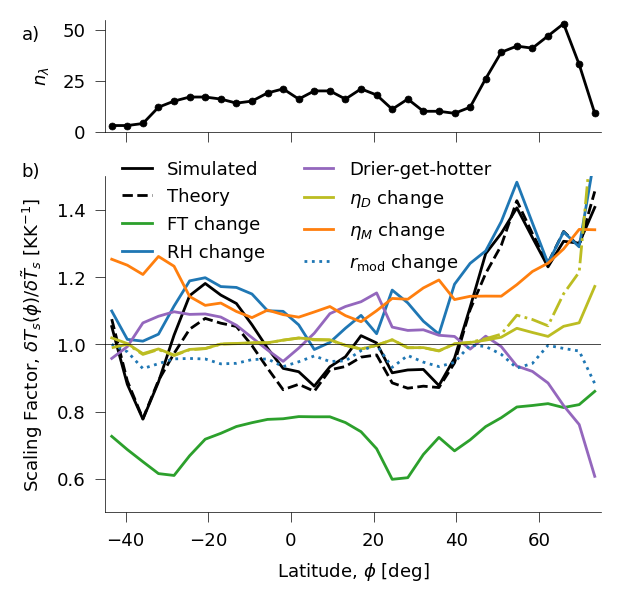

In [24]:
# Ensure when averaging over latitude for each quant, that weight the more convective latitudes more
thresh_sf_individual = 0.04
label_lat = 'Latitude, $\phi$ [deg]'
label_sf_zm = utils.sf_label.replace('x', '\phi').replace('overline', 'tilde')    # tilde because use overline later in spatial, slightly different
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, sharex=True)
fig_resize(fig, width['one_col'], ar=2)
ax[0].plot(mask_loc.lat, mask_loc.sum(dim='lon'), color='k', marker='o')
ax[0].set_ylim(0, 55)
ax[0].set_yticks([0, 25, 50])
ax[0].set_ylabel('$n_{\lambda}$')

for key in ['', '_sum']:
    ax[1].plot(ds_sf_lat.lat, ds_sf_lat[f"scale_factor{key}"],
               color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
               label=style_map[f"scale_factor{key}"][2])
# ax.plot(ds_sf_num.quant,
#         np.average(ds_sf_num[f"scale_factor_linear"] + ds_sf_num[f"nl_r_change"] - 1, axis=0, weights=lat_weights),
#         color='k', linestyle='--', label='Linear + nl_r_change')
for key in ds_sf_lat:
    if 'scale_factor' in key:
        continue
    elif 'nl' in key:
        continue
    if np.nanmax(np.abs(ds_sf_lat[key] - 1)) < thresh_sf_individual:
        continue
    ax[1].plot(ds_sf_lat.lat, ds_sf_lat[key], label=style_map[key][2].replace('Hot', 'Cold'),
               color=style_map[key][0],
               linestyle=style_map[key][1])

ax[1].plot(ds_sf_lat.lat, (ds_sf_lat['lapse_D_change']-1)/ds_lat.lapse_D.diff(dim='co2').squeeze() *
           ds_lat.lapse_D_no_clip.diff(dim='co2').squeeze() + 1,
           color='C8', linestyle='-.')

update_linewidth(fig)
ax[1].legend(ncol=2, handlelength=leg_handlelength, bbox_to_anchor=(0, 1.1), loc='upper left')
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[1].set_xlabel(label_lat)
ax[1].set_ylabel(label_sf_zm)
ax[1].set_xlim(lat_min, lat_max)
ax[1].set_ylim(0.5, 1.5)
# ax[0].legend(ncol=2)
label_subplots(fig, ax[0], pos_x=-30, box_alpha=0, pos_y=-2, labels=['a)'])
label_subplots(fig, ax[1], pos_x=-30, box_alpha=0, pos_y=5, labels=['b)'])
update_fontsize(fig, 6.5)
plt.show()
# savefig(fig)

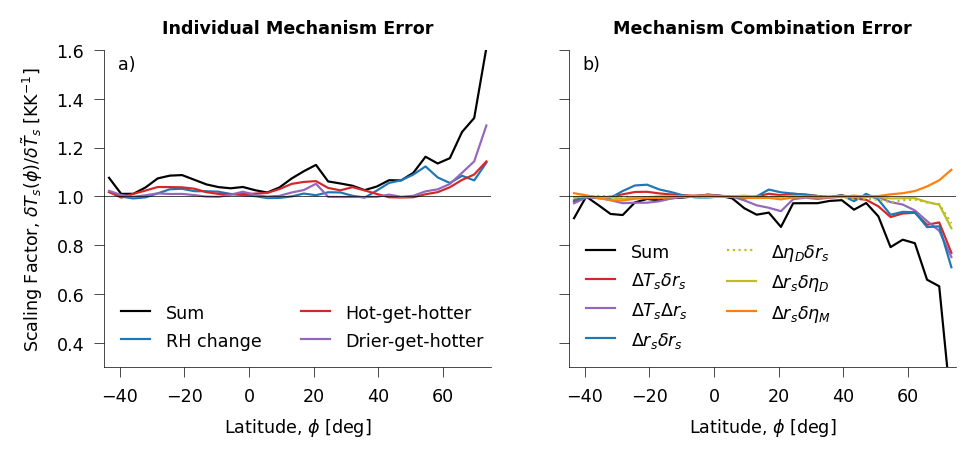

In [25]:
 #%%capture
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
# fig_resize(fig, 10)
ax[0].set_title('Individual Mechanism Error', fontweight='bold')
ax[1].set_title('Mechanism Combination Error', fontweight='bold')
ax[0].plot(ds_sf_lat_num.lat,
           (ds_sf_lat_num['scale_factor_linear'] - ds_sf_lat['scale_factor_sum'] + 1),
           color='k', label='Sum')
ax[1].plot(ds_sf_lat_num.lat, ds_sf_lat_num['nl_sum'],
           color='k', linestyle='-', label='Sum')

# Plot individual mechanism error
for key in ds_sf_lat:
    if 'scale_factor' in key:
        continue
    if 'rh_mod' in key:
        continue
    if np.nanmax(np.abs(ds_sf_lat_num[key] - 1)) < thresh_sf_individual:
        continue
    if np.nanmax(np.abs(ds_sf_lat_num[key] - 1)) > thresh_sf_individual:
        ax[0].plot(ds_sf_lat.lat, ds_sf_lat_num[key], label=style_map[key][2],
                   color=style_map[key][0],
                   linestyle=style_map[key][1])

# Plot combination of mechanism error
for key in ds_sf_lat_num:
    if ('nl' not in key) or ('sum' in key) or ('error' in key) or ('scale_factor' in key) or ('residual' in key):
        continue
    if np.nanmax(np.abs(ds_sf_lat_num[key] - 1)) > 0.10:
        # ax[1].plot(ds_sf_lat.lat, ds_sf_lat_num[key], label=key)
        ax[1].plot(ds_sf_lat.lat, ds_sf_lat_num[key], label=style_map[key][2],
                   color=style_map[key][0], linestyle=style_map[key][1])
# key = 'nl_error_av_change'
# ax[1].plot(ds_sf_lat.lat, ds_sf_lat_num[key], label=key, color='C6')
# key = 'nl_residual'
# ax[1].plot(ds_sf_lat.lat, ds_sf_lat_num[key], label=key, color='C6')
update_linewidth(fig)

# Reorder ax1 legend
# handles, labels = ax[1].get_legend_handles_labels()
# order = [0, 1, 2, 4, 3, 5]  # desired new order by index
# ax[1].legend([handles[i] for i in order],
#              [labels[i] for i in order], ncol=2, handlelength=leg_handlelength)
ax[0].legend(ncol=2, handlelength=leg_handlelength, loc='lower left')
ax[1].legend(ncol=2, handlelength=leg_handlelength, loc='lower left')
label_subplots(fig, ax, pos_y=-2)
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[0].set_xlabel(label_lat)
ax[1].set_xlabel(label_lat)
ax[0].set_ylabel(label_sf_zm)
update_fontsize(fig)
ax[0].set_ylim(0.3, 1.6)
ax[0].set_xlim(lat_min, lat_max)
plt.show()
# savefig(fig)

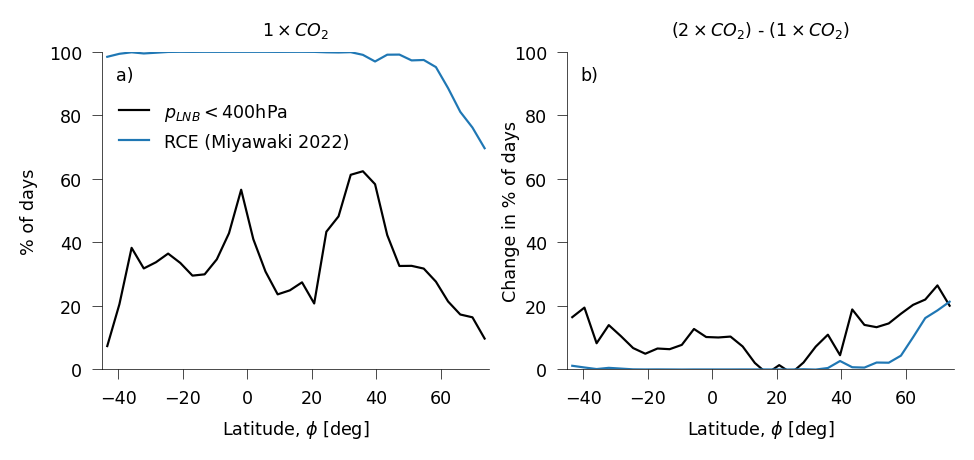

In [26]:
# Probably can just show a spatial version of the right plot
fig, ax = plt.subplots(1, 2, sharex=True)
fig_resize(fig, width['two_col'])
# n_sample = (ds_coarse.mask_conv & mask_loc).sum(
#     dim=['sample', 'lon'])  # total number of convective days at each location
# var = (ds_coarse.p_lnb_approx.where(ds_coarse.mask_conv & mask_loc) < p_ft).sum(dim=['sample', 'lon']) / n_sample * 100
ax[0].plot(ds_lat.lat, ds_lat['p_lnb_frac'].isel(co2=0), color=f"k", label='$p_{LNB} < ' + f'{p_ft / 100:.0f}$hPa')
ax[1].plot(ds_lat.lat, ds_lat['p_lnb_frac'].diff(dim='co2').squeeze(), color=f"k")

# var = (ds_coarse.lapse_miy2022_M.where(ds_coarse.mask_conv & mask_loc) < lapse_miy2022_M_thresh).sum(
#     dim=['sample', 'lon']) / n_sample * 100
ax[0].plot(ds_lat.lat, ds_lat['lapse_miy2022_frac_RCE'].isel(co2=0), color=f"C0",
           label='RCE (Miyawaki 2022)')
ax[1].plot(ds_lat.lat, ds_lat['lapse_miy2022_frac_RCE'].diff(dim='co2').squeeze(), color=f"C0")

update_linewidth(fig)
ax[0].legend(handlelength=leg_handlelength, bbox_to_anchor=(0, 0.9), loc='upper left')
ax[1].legend(handlelength=leg_handlelength)
ax[0].set_xlim(lat_min, lat_max)
for i in range(len(ax)):
    ax[i].set_ylim(0, 100)
    ax[i].set_xlabel(label_lat)
ax[0].set_ylabel('% of days')
ax[1].set_ylabel('Change in % of days', labelpad=-2)
ax[0].set_title(utils.co2_labels[0])
ax[1].set_title(f'({utils.co2_labels[1]}) - ({utils.co2_labels[0]})')
label_subplots(fig, ax, box_alpha=0)
update_fontsize(fig)
plt.show()
# savefig(fig)

## Spatial Scaling factor
Below I plot the spatial distribution of the above scaling factor, I plot the theoretical scaling factor and contribution from each mechanism

In [27]:
if not load_from_file:
    ds_spatial = ds_coarse.where(ds_coarse.mask_conv & mask_loc).weighted(ds_coarse.lat_weights).mean(dim='sample')
    ds_spatial.attrs = ds_coarse.attrs
    ds_spatial['rh_mod'] = ds.rh_mod[ds_coarse.mod_parcel_rh_mod_ind].where(ds_coarse.mask_conv & mask_loc
                                                                            ).weighted(ds_coarse.lat_weights).mean(
        dim='sample')
    ds_spatial['n_valid'] = (ds_coarse.mask_conv & mask_loc).sum(dim='sample')
    ds_spatial['FREQZM_frac'] = (ds_coarse.FREQZM>0).where(ds_coarse.mask_conv & mask_loc).sum(dim='sample') / ds_spatial['n_valid'] * 100

    # Add all variables needed for notebook to ds_spatial so don't need ds_coarse
    ds_spatial.attrs['mask_lapse_D_clip_thresh'] = 100                 # Mask where atleast 100 days have lapse_D clipped
    ds_spatial['mask_lapse_D_clip'] = ((ds_coarse.lapse_D_no_clip<ds_coarse.thresh_lapse_D_clip).where(ds_coarse.mask_conv & mask_loc).sum(dim='sample')
                                       >ds_spatial.mask_lapse_D_clip_thresh)

    ds_spatial['mean_doy'] = xr_circmean(ds_coarse.dayofyear.where(ds_coarse.mask_conv), dims="sample", low=1, high=365,
                                         nan_policy="omit")         # av day of year on which hot days occur
    ds_spatial.attrs['temp_ft_pos_anom_thresh'] = 2                 # Frac of days anomalously hot at FT
    ds_spatial['temp_ft_pos_anom_frac'] = (ds_coarse.T_ft_env_anom.where(ds_coarse.mask_conv)>
                                           ds_spatial.temp_ft_pos_anom_thresh).sum(dim='sample')/ds_spatial['n_valid'] * 100


    # Get fraction of days 7 hours after local midday or before local midday
    ds_spatial.attrs['cold_hour_thresh_above'] = ds_lat.attrs['cold_hour_thresh_above']
    ds_spatial.attrs['cold_hour_thresh_below'] = ds_lat.attrs['cold_hour_thresh_below']
    ds_spatial['cold_hour_frac'] = ((ds_coarse.time_from_midday > ds_spatial.cold_hour_thresh_above) | (
            ds_coarse.time_from_midday < ds_spatial.cold_hour_thresh_below)
                                ).where(ds_coarse.mask_conv & mask_loc).sum(dim='sample') / ds_spatial.n_valid * 100

In [28]:
save_all_ds = True
if not load_from_file:
    if save_all_ds:
        if os.path.exists(out_path):
            print(f'File already exists at {out_path}')
        else:
            ds_out = DataTree.from_dict({
                "ds_lat": ds_lat,
                "ds_spatial": ds_spatial,
                "ds_av_global": ds_av_global,
                "mask_loc": mask_loc.to_dataset(name="mask_loc"),
            })

            complev = dict(zlib=True, complevel=4)
            encoding = {}
            for grp in ds_out.groups:
                node = ds_out[grp]
                if node.ds is None:
                    continue
                encoding[grp] = {v: complev for v in node.ds.data_vars}
            ds_out.to_netcdf(out_path, format="NETCDF4", encoding=encoding)

In [29]:
norm_by_av_spatial = True  # so change mechanisms normalized about 1
ds_sf_spatial = []
for i in tqdm(range(ds_spatial.lat.size)):
    ds_sf_spatial.append(
        utils.apply_sf_theory_with_rh_mod(ds_spatial.isel(lat=i), ds_ref_global, p_ft, temp_surf_lcl_calc,
                                          quant_dim='lon', numerical=False))
ds_sf_spatial = xr.concat(ds_sf_spatial, dim=ds_spatial.lat)
if norm_by_av_spatial:
    # Make sf relative to average day not the ref day - so temp_ft centered on zero etc...
    ds_sf_av_spatial = utils.apply_sf_theory_with_rh_mod(
        ds_av_global.expand_dims({"newdim": [0]}), ds_ref_global, p_ft, temp_surf_lcl_calc,
        quant_dim='newdim', numerical=False).isel(newdim=0, drop=True)
    for key in ds_sf_spatial:
        ds_sf_spatial[key] = ds_sf_spatial[key] - ds_sf_av_spatial[key] + 1

path_output_sf_spatial_num = os.path.join(utils.out_dir, 'ds_sf_spatial_global.nc')
if os.path.exists(path_output_sf_spatial_num):
    ds_sf_spatial_num = xr.load_dataset(path_output_sf_spatial_num)
else:
    # Takes 10 mins for 4 x 4 grid
    ds_sf_spatial_num = []
    for i in tqdm(range(ds_spatial.lat.size)):
        ds_sf_spatial_num.append(
            utils.apply_sf_theory_with_rh_mod(ds_spatial.isel(lat=i), ds_ref_global,
                                              p_ft, temp_surf_lcl_calc, quant_dim='lon', numerical=True))
    ds_sf_spatial_num = xr.concat(ds_sf_spatial_num, dim=ds_spatial.lat)
    # ds_spatial = xr.
    if norm_by_av_spatial:
        # Make sf relative to average day not the ref day - so temp_ft centered on zero etc...
        ds_sf_av_spatial_num = \
            utils.apply_sf_theory_with_rh_mod(ds_av_global.expand_dims({"newdim": [0]}), ds_ref_global,
                                              p_ft, temp_surf_lcl_calc, quant_dim='newdim',
                                              numerical=True).isel(newdim=0, drop=True)
        for key in ds_sf_spatial_num:
            ds_sf_spatial_num[key] = ds_sf_spatial_num[key] - ds_sf_av_spatial_num[key] + 1

  0%|          | 0/32 [00:00<?, ?it/s]

In [30]:
# Get total non-linear contribution due to combination of any 2 mechanisms
ds_sf_spatial_num["nl_sum"] = ds_sf_spatial_num['scale_factor_nl'] - ds_sf_spatial_num['scale_factor_linear'] + 1
# Set numerical method to show difference to linear theory
for key in ds_sf_spatial:
    if 'scale_factor_sum' in key:
        continue
    if 'rh_mod' in key:
        continue
    if 'rh' in key:
        # combine physical and mod linear contributions as done in numerical
        var = ds_sf_spatial[key] + ds_sf_spatial[key.replace('rh', 'rh_mod')] - 1
    else:
        var = ds_sf_spatial[key]
    ds_sf_spatial_num[key] = ds_sf_spatial_num[key] - var + 1

In [31]:
# Compute scale factor from just hange contribution or just anom contribution
var_names_change = [key for key in ds_sf_spatial if not
(('sum' in key) or ('error' in key) or ('scale_factor' in key) or ('nl' in key) or ('anom' in key))]
var_names_anom = [key for key in ds_sf_spatial if not
(('sum' in key) or ('error' in key) or ('scale_factor' in key) or ('nl' in key) or ('change' in key))]
ds_sf_spatial['scale_factor_change'] = (ds_sf_spatial[var_names_change].to_array(dim="feature") - 1).sum(
    dim='feature') + 1
ds_sf_spatial['scale_factor_anom'] = (ds_sf_spatial[var_names_anom].to_array(dim="feature") - 1).sum(dim='feature') + 1

In [32]:
# Indicate where non-linear anom mechanisms important - all locations important are where rh_anom important
thresh_mask_nl = 0.2
mask_nl_anom = ds_sf_spatial_num.scale_factor < 0
for key in ds_sf_spatial_num:
    if ('scale_factor' in key) or ('sum' in key) or ('error' in key) or ('change' in key) or ('residual' in key):
        continue
    if (np.abs(ds_sf_spatial_num[key] - 1) > thresh_mask_nl).any():
        print(key, (np.abs(ds_sf_spatial_num[key] - 1) > thresh_mask_nl).sum().values)
        mask_nl_anom = mask_nl_anom | (np.abs(ds_sf_spatial_num[key] - 1) > thresh_mask_nl)
# mask_non_rh_anom = mask_non_rh_anom | (np.abs(ds_sf_spatial.p_surf_anom - 1) > thresh_mask_anom) | \
#                    (np.abs(ds_sf_spatial.temp_surf_anom - 1) > thresh_mask_anom)
mask_nl_anom = mask_nl_anom & mask_loc
# mask_nl_anom = mask_loc & (np.abs(ds_sf_spatial_num['rh_anom'] - 1) > thresh_mask_nl)

# Indicate where non-linear change mechanisms important
mask_nl_change = ds_sf_spatial_num.scale_factor < 0
for key in ds_sf_spatial_num:
    if ('scale_factor' in key) or ('sum' in key) or ('error' in key) or ('change' not in key):
        continue
    mask_nl_change = mask_nl_change | (np.abs(ds_sf_spatial_num[key] - 1) > thresh_mask_nl)
mask_nl_change = mask_loc & mask_nl_change

temp_surf_anom 2
rh_anom 43
nl_temp_surf_anom_rh_anom 20


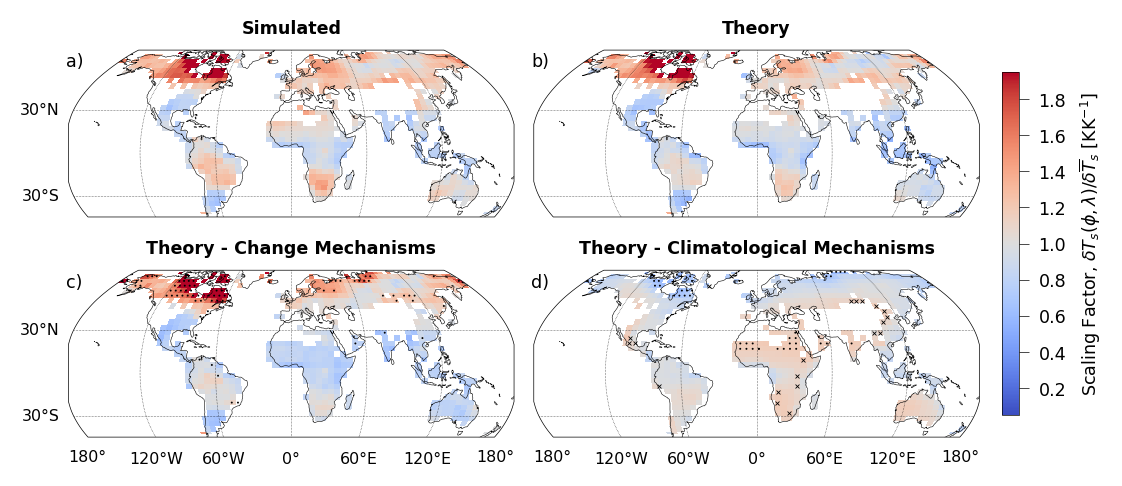

In [33]:
label_sf_spatial = utils.sf_label.replace('x', '\phi, \lambda')
sf_clim = [0.05, 1.95]
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
fig_resize(fig, width['two_col'], ar=2.4)
for i, ax_use in enumerate(ax.flatten()):
    gl = utils.initialize_ax_projection(ax_use, lat_min=lat_min, lat_max=lat_max, grid_lat=[-30, 30], return_gl=True,
                                        coastline_lw=0.2, gridline_lw=0.2)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    if i <= 1:
        gl.bottom_labels = False
    if i % 2:
        gl.left_labels = False
utils.plot_contour_projection(ax[0, 0], ds_sf_spatial.scale_factor.where(mask_loc), cmap='coolwarm',
                              imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1],
                                                          'extent': (0, 360, lat_min, lat_max)})
utils.plot_contour_projection(ax[0, 1], ds_sf_spatial.scale_factor_sum.where(mask_loc),
                              cmap='coolwarm', imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1],
                                                                           'extent': (0, 360, lat_min, lat_max)})
utils.plot_contour_projection(ax[1, 0], ds_sf_spatial.scale_factor_change.where(mask_loc),
                              cmap='coolwarm', imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1],
                                                                           'extent': (0, 360, lat_min, lat_max)})
im = utils.plot_contour_projection(ax[1, 1], ds_sf_spatial.scale_factor_anom.where(mask_loc),
                                   cmap='coolwarm', imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1],
                                                                                'extent': (0, 360, lat_min, lat_max)})

# Indicate where nl mechanisms important
plot_scatter_mask(mask_nl_change, ax[1, 0], s=2)
plot_scatter_mask(mask_nl_anom, ax[1, 1], s=2)

# Indicate where non drier-get-hotter mechanism important. I think only these two have contribution of magnitude greater than 0.05.
# No negative contributions have contribution less than -0.05.
plot_scatter_mask(np.abs(ds_sf_spatial.rh_mod_anom-1) > 0.06, ax[1, 1], s=2, marker='+', linewidths=0.3)
plot_scatter_mask(np.abs(ds_sf_spatial.p_surf_anom-1) > 0.06, ax[1, 1], s=2, marker='x', linewidths=0.3)

label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=-1, pos_x=-1)
plt.colorbar(im, ax=ax[:, 1].ravel(), label=label_sf_spatial, shrink=0.85, ticks=np.arange(0.2, 2, 0.2))
ax[0, 0].set_title('Simulated', fontweight='bold')
ax[0, 1].set_title('Theory', fontweight='bold')
ax[1, 0].set_title('Theory - Change Mechanisms', fontweight='bold')
ax[1, 1].set_title('Theory - Climatological Mechanisms', fontweight='bold')
update_fontsize(fig)
plt.show()
# savefig(fig)

### Individual change mechanisms
Below I plot the individual change mechanisms responsible for the scaling factor. This is not necessary for the climatological mechanisms, as entirely dominated by drier get hotter.

In [34]:
show_fig = False        # not used in thesis, but combined with clusters
if show_fig:
    fig = plt.figure(constrained_layout=True)
    ax = fig.subplots(3, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
    var_order = ['temp_ft', 'rh', 'lapse_D', 'lapse_M', 'rh_mod', 'p_surf']
    for i, ax_use in enumerate(ax.flatten()):
        gl = utils.initialize_ax_projection(ax_use, lat_min=lat_min, lat_max=lat_max, grid_lat=[-30, 30], return_gl=True,
                                            coastline_lw=0.2, gridline_lw=0.2)[1]
        gl.xlabel_style = {"size": gl_fontsize}
        gl.ylabel_style = {"size": gl_fontsize}
        if i <= 3:
            gl.bottom_labels = False
        if i % 2:
            gl.left_labels = False

        ax_use.set_title(utils.labels_cont[f"{var_order[i]}_change"], fontweight='bold')
        im = utils.plot_contour_projection(ax_use, ds_sf_spatial[f"{var_order[i]}_change"].where(mask_loc),
                                           cmap='coolwarm', imshow=True,
                                           imshow_kwargs={'vmin': 0.7, 'vmax': 1.3,
                                                          'extent': (0, 360, lat_min, lat_max)})
        if 'rh_mod' in var_order[i]:
            continue
        mask_nl_use = np.abs(ds_sf_spatial_num[f"{var_order[i]}_change"] - 1) > thresh_mask_nl
        if mask_nl_anom.any():
            plot_scatter_mask(mask_nl_use, ax_use, s=2)

    # Mask where over 100 days clipped in preindustrial simulation
    plot_scatter_mask(ds_spatial['mask_lapse_D_clip'].isel(co2=0), ax.flatten()[2], s=2, marker='x', linewidths=0.3)

    fig_resize(fig, width['two_col'], ar=2.5)
    plt.colorbar(im, ax=ax[:, 1].ravel(), label=utils.sf_label, shrink=0.95, ticks=np.arange(0.7, 1.4, 0.1))
    label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=-1, pos_x=-1)
    update_fontsize(fig)
    plt.show()
    # savefig(fig)

In [35]:
# Link between convection and RH in tropics to say there is more convection over regions which moisten e.g. Africa not South America
# But then circular argument for Mariana's paper linking convection in Africa to drying in Amazon
# xr.corr(np.sign(ds_spatial['FREQZM_frac'].diff(dim='co2').sel(lat=slice(-20, 20))),
#         np.sign(ds_spatial['rh_REFHT'].diff(dim='co2').sel(lat=slice(-20, 20))))

## Clustering
Here I perform clustering on the change mechanisms, to highlight the regions where mechanisms are extreme. I first convert scaling factor contribution to binary grid based on if higher than a threshold, then I find the unique values of this grid with more than 10 counts to initialize k-means.

Then I do k-means, with the actual values clipped at 0.1, without updating atoms, and removing clusters with less than 20 counts.

The idea is that rather than showing the 4 individual mechanisms, we combine them onto a single figure.
Probably should include the full 4 mechanisms in the appendix though.

In [36]:
def _prepare_X(ds, var_names, clamp_thresh=None):
    X = ds[var_names].to_array(dim="feature")  # (feature, lat, lon)
    Xs = X.stack(sample=("lat", "lon")).transpose("sample", "feature")  # (sample, feature)
    valid = np.isfinite(Xs).all("feature")
    X_valid = Xs.sel(sample=valid)

    if clamp_thresh is not None:
        # This is to get extreme values in binary grid. Anything with larger absolute value than clamp_thresh set to \pm 1
        # Other values set to zero
        X_binary = X_valid.where(np.abs(X_valid) > clamp_thresh)
        X_binary = (X_binary < 0) * (-clamp_thresh) + (X_binary > 0) * clamp_thresh
        X_valid = np.clip(X_valid, -clamp_thresh, clamp_thresh)  # clip X valid between extreme values
    else:
        X_binary = X_valid * 1
    return np.asarray(X_valid.data), X_valid['sample'], np.asarray(X_binary.data)


def remove_duplicate_clusters(centroids, labels):
    # centroids: (cluster, feature)

    # unique centroid rows, and mapping from old cluster -> unique centroid index
    C_unique, inverse = np.unique(centroids, axis=0, return_inverse=True)  # inverse shape (n_clusters,)
    # optional: counts of how many clusters share each unique centroid
    # _, counts = np.unique(inverse, return_counts=True)

    # has_duplicates = (C_unique.shape[0] < centroids.shape[0])
    #
    # # which original clusters are duplicates of an earlier centroid
    # dup_mask = np.ones(centroids.shape[0], dtype=bool)
    # dup_mask[np.unique(inverse, return_index=True)[1]] = False  # False for first occurrence, True for duplicates
    # dup_clusters = np.where(dup_mask)[0]

    labels_new = inverse[labels]  # vectorized remap old->new
    return C_unique, labels_new


def kmeans_no_update_on_xarray(
        ds: xr.Dataset,
        var_names=None,
        init_centroids=None,
        max_iter=200,
        min_points_init=10,
        min_points_final=20,
        clamp_thresh=0.1,
):
    """
    K-means on (lat, lon) grid with constrained centroids:
      var_names_zero = {k: ["feat1","feat2",...], ...}


    init_centroids:
      - None: random init from samples
      - np.ndarray of shape (n_clusters, n_features): used directly
      - xr.DataArray with dims ('cluster','feature') and matching feature names: aligned by feature coord

    Note: This mirrors the idea that k-means can accept an explicit initial center array. [web:34]
    """
    if var_names is None:
        var_names = list(ds.data_vars)

    # (feature, lat, lon)
    Xw, sample_coord, X_binary = _prepare_X(ds, var_names, clamp_thresh)
    n_samples, n_features = Xw.shape

    # --- init centroids ---
    if init_centroids is None:
        #
        vectors, counts = np.unique(X_binary, axis=0, return_counts=True)
        centroids = vectors[counts > min_points_init]
    else:
        if isinstance(init_centroids, xr.DataArray):
            # align by feature name if possible
            if "feature" in init_centroids.dims and "feature" in init_centroids.coords:
                initC = init_centroids.sel(feature=var_names).data
            else:
                initC = init_centroids.data
            centroids = np.asarray(initC, dtype=float).copy()
        else:
            centroids = np.asarray(init_centroids, dtype=float).copy()
    n_clusters = centroids.shape[0]
    if centroids.shape[1] != n_features:
        raise ValueError(
            f"init_centroids has shape {centroids.shape}, expected ({n_clusters},{n_features})"
        )
    prev_labels = None
    for i in range(max_iter):
        print(f'Iteration {i+1} | n_clusters = {n_clusters}')
        # assign step (squared Euclidean)
        dists = ((Xw[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2)
        labels = dists.argmin(axis=1)

        # NEW stopping criterion: assignments unchanged
        if prev_labels is not None and np.array_equal(labels, prev_labels):
            break
        prev_labels = labels.copy()

        # update step (means / reseed empties)
        for k in range(n_clusters):
            members = (labels == k)
            if members.sum() < min_points_final:
                centroids[k] = 0
        centroids, labels = remove_duplicate_clusters(centroids, labels)
        n_clusters = centroids.shape[0]
    n_points = np.unique(labels, return_counts=True)[1]
    # back to (lat, lon)
    labels_1d = xr.DataArray(
        labels,
        coords={"sample": sample_coord},
        dims=("sample",),
        name="cluster",
    )
    labels_map = labels_1d.unstack("sample").reindex(lat=ds["lat"], lon=ds["lon"])

    centroids_da = xr.DataArray(
        centroids,
        coords={"cluster": np.arange(centroids.shape[0]), "feature": var_names},
        dims=("cluster", "feature"),
        name="centroid",
    )

    return labels_map, centroids_da, n_points


In [37]:
var_names_change = [key for key in ds_sf_spatial if not
(('sum' in key) or ('error' in key) or ('scale_factor' in key) or (
        'anom' in key))]

labels, centroids, n_labels = kmeans_no_update_on_xarray(ds_sf_spatial - 1, var_names_change, min_points_final=50)
print('Number of coordinates in each final cluster:', n_labels)

Iteration 1 | n_clusters = 15
Iteration 2 | n_clusters = 6
Iteration 3 | n_clusters = 6
Number of coordinates in each final cluster: [ 71 107  88  83 140 136]


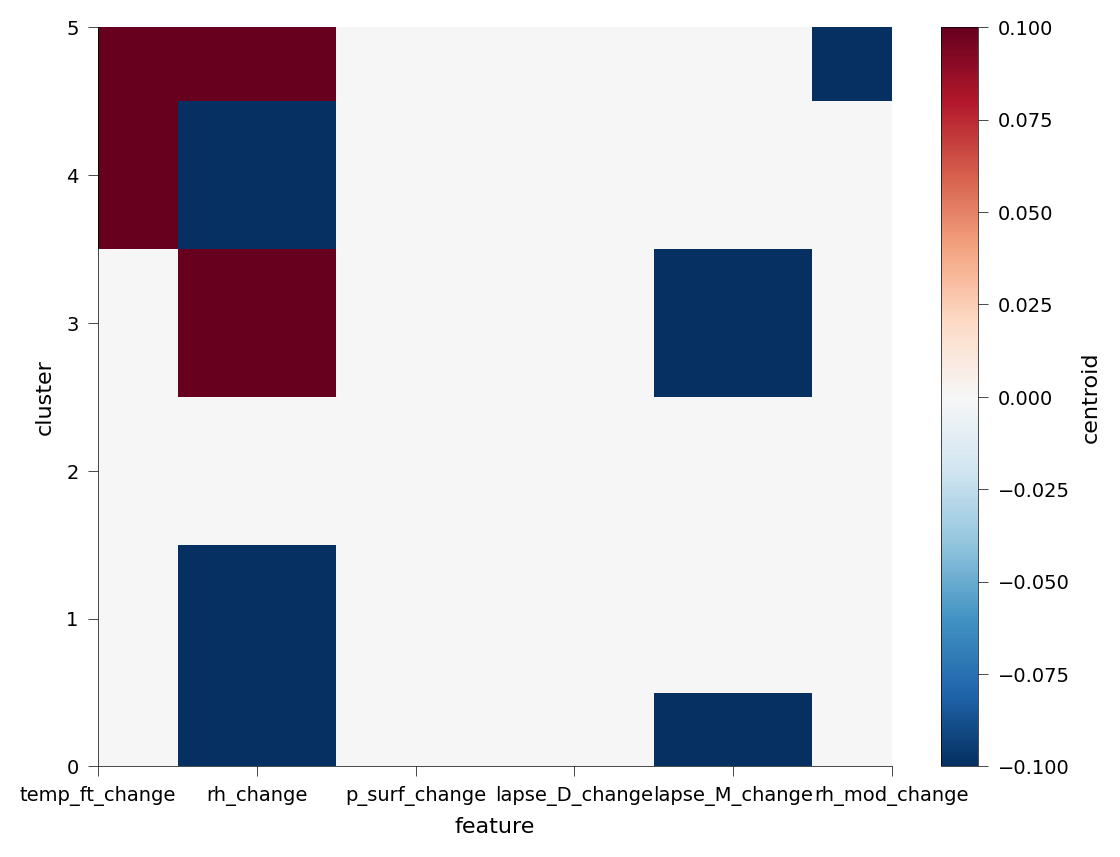

In [38]:
centroids.plot()
plt.show()

In [39]:
# After you made the plot and have the colorbar:
def cbar_multi_color_labels(cbar, label_segments, y_offset=0.3):
    # Function to write colorbar lables in more than one color
    # cbar = m.colorbar
    axc = cbar.ax

    ticks = np.arange(K)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([""] * K)  # hide default tick labels
    cbar.ax.tick_params(which="both", length=0)

    # label_segments[cid] = [("hi ", "red"), ("bye", "blue")]
    for i in range(len(label_segments)):
        segs = label_segments[i]

        # Build multi-colored, single-line label
        children = [
            TextArea(txt, textprops=dict(color=col, va="center"))
            for (txt, col) in segs
        ]
        hbox = HPacker(children=children, align="center", pad=0, sep=0)  # pack inline [web:97]

        # Place it at (x,y) in "y in data, x in axes fraction"
        ab = AnnotationBbox(
            hbox,
            (1.3, i),  # just right of the colorbar
            xycoords=axc.get_yaxis_transform(),  # x in axes, y in data coords
            box_alignment=(0.0, y_offset),
            frameon=False,
            pad=0.0,
            clip_on=False,
        )
        axc.add_artist(ab)
    return None

In [40]:
# Inputs you provide
# labels_map: DataArray (lat, lon) with integer labels
# color_dict: {cluster_id: "C0", ...} (any valid Matplotlib color)
# name_dict:  {cluster_id: "Blocked", ...} (your display names)
# desired_order: list/array of cluster_ids in the order you want on the colorbar
# e.g. desired_order = [3, 0, 2, 1]


# desired_order = [2, 1, 0, 3, 4, 5, 6, 7]  # order in legend
# # Colormap in the order you want to show
# colors_cluster = ['navy', 'blue', 'lightgray', 'springgreen', 'olive', 'green', 'mistyrose', 'red']
# label_segments = [[('$r_s \eta_M$', 'blue')],
#                   [('$r_s$', 'blue')],
#                   [],
#                   [('$r_s$', 'C3'), ('$\eta_M$', 'blue')],
#                   [('$T_{FT}$', 'C3'), ('$r_s$', 'blue')],
#                   [('$T_{FT}$', 'C3'), ('$r_s$', 'blue'), ('$\eta_M$', 'C3')],
#                   [('$T_{FT} r_s \eta_M$', 'C3')],
#                   [('$T_{FT} r_s \eta_M \eta_D$', 'C3')]]
desired_order = [2, 0, 1, 4, 3, 5]  # order in legend
# Colormap in the order you want to show
colors_cluster = ['navy', 'blue', 'lightgray', 'mistyrose', 'skyblue', 'red']
label_segments = [[('$r_s \eta_M$', 'blue')],
                  [('$r_s$', 'blue')],
                  [],
                  [('$r_s$', 'C3'), ('$\eta_M$', 'blue')],
                  [('$r_s$', 'blue'), ('$T_{FT}$', 'C3')],
                  [('$r_sT_{FT}$', 'C3'), ('$r_{\\text{mod}}$', 'blue')]]

# desired_order: cluster ids in the order you want shown on the colorbar
K = len(desired_order)

# Build mapping: original cluster id -> plotting code 0..K-1
id_to_code = {cid: i for i, cid in enumerate(desired_order)}

# Remap the DataArray (vectorized via NumPy indexing)
max_id = int(labels.max())
lut = np.full(max_id + 1, -1, dtype=int)  # -1 for "unknown" (optional)
for cid, code in id_to_code.items():
    lut[cid] = code

labels_code = xr.apply_ufunc(
    lambda x: lut[x],
    labels.astype(int),
    dask="allowed",
    output_dtypes=[int],
)

# Colormap in desired order
cmap = mcolors.ListedColormap([colors_cluster[cid] for cid in desired_order], name="clusters")
bounds = np.arange(-0.5, K + 0.5, 1)  # monotonic edges
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # discrete mapping [web:41]

In [41]:
show_fig = False    # not used in thesis, but combined is.
if show_fig:
    fig = plt.figure(constrained_layout=True)
    ax = fig.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
    fig_resize(fig, width['two_col'], ar=3)
    gl = utils.initialize_ax_projection(ax, lat_min=lat_min, lat_max=lat_max, coastline_lw=0.2, grid_lat=[-30, 30],
                                        return_gl=True, gridline_lw=0.2)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    im = utils.plot_contour_projection(ax, labels_code.where(mask_loc), imshow=True, cmap=cmap,
                                       imshow_kwargs={'norm': norm, 'extent': (0, 360, lat_min, lat_max)})
    cbar = plt.colorbar(im, ax=ax, ticks=np.arange(K), pad=0.01, shrink=1, aspect=15)

    cbar_multi_color_labels(cbar, [label_segments[i] for i in desired_order])
    cbar.set_label('')
    # Custom tick labels (cluster names) [web:47]
    # cbar = m.colorbar
    # cbar.set_ticklabels([name_dict[cid] for cid in desired_order])

    # There is no cluster with positive \eta_M so put scatter plot of these to show where important positive contribution
    plot_scatter_mask(ds_sf_spatial.lapse_M_change>1.1, ax, s=5, color='C1')
    # ax.set_title("Clusters")
    update_fontsize(fig, base_fontsize=6)
    # savefig(fig)
    plt.show()

### Combined figure
It is easier to have the individual changes and clusters in the same Figure, so I combine them below. There are various markers:

* Black dots throughout indicate where nonlinear contribution to that particular mechanism absolute contribution > 0.2.
* Black $\times$ in $\eta_D$ figure where clipping done in preindustrial simulation.
* Orange $\times$ in bottom figure where $\eta_M$ mechanism has positive contribution greater than 0.1.

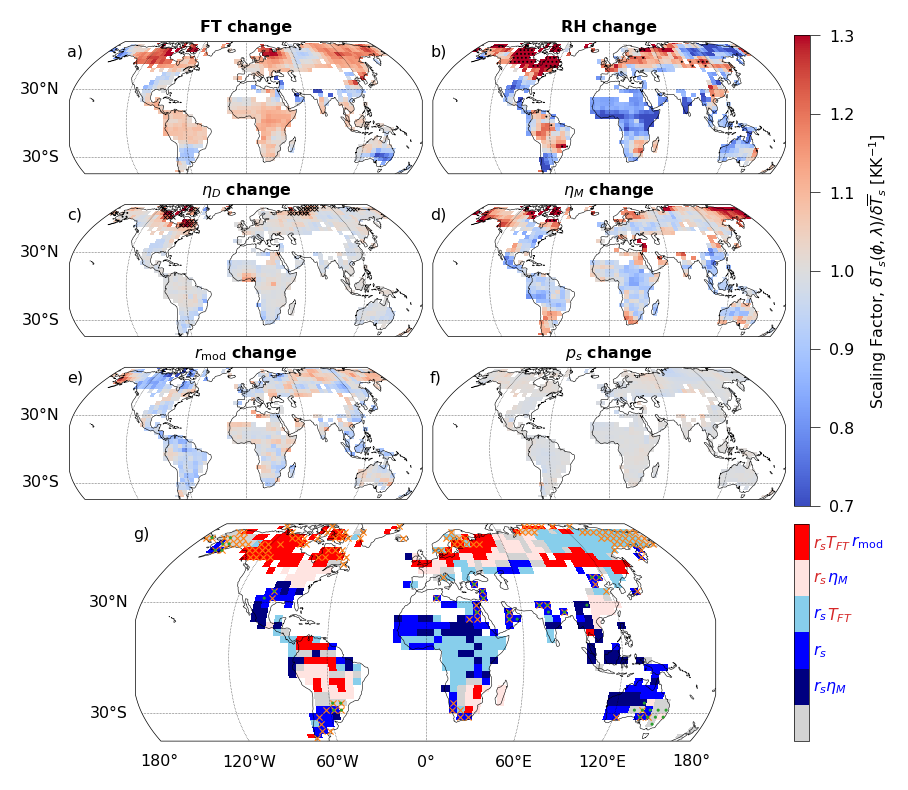

In [42]:
fig = plt.figure()

gs = fig.add_gridspec(4, 2, hspace=0.11, height_ratios=[1, 1, 1, 1.5], wspace=0.03)

# first 3 rows: normal 2 columns (6 subplots)
ax = []
for r in range(3):
    for c in range(2):
        ax.append(fig.add_subplot(gs[r, c], projection=ccrs.Robinson()))

# bottom row: span both columns (1 subplot)
ax.append(fig.add_subplot(gs[3, :], projection=ccrs.Robinson()))

var_order = ['temp_ft', 'rh', 'lapse_D', 'lapse_M', 'rh_mod', 'p_surf']
for i, ax_use in enumerate(ax):
    gl = utils.initialize_ax_projection(ax_use, lat_min=lat_min, lat_max=lat_max, grid_lat=[-30, 30], return_gl=True,
                                        coastline_lw=0.2, gridline_lw=0.2)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    if i <= 5:
        gl.bottom_labels = False
    if i % 2:
        gl.left_labels = False
    if i >= 6:
        continue
    ax_use.set_title(utils.labels_cont[f"{var_order[i]}_change"], fontweight='bold', y=0.95)
    im = utils.plot_contour_projection(ax_use, ds_sf_spatial[f"{var_order[i]}_change"].where(mask_loc),
                                       cmap='coolwarm', imshow=True,
                                       imshow_kwargs={'vmin': 0.7, 'vmax': 1.3,
                                                      'extent': (0, 360, lat_min, lat_max)})
    if 'rh_mod' in var_order[i]:
        continue
    mask_nl_use = np.abs(ds_sf_spatial_num[f"{var_order[i]}_change"] - 1) > thresh_mask_nl
    if mask_nl_anom.any():
        plot_scatter_mask(mask_nl_use, ax_use, s=2)

# Mask where over 100 days clipped in preindustrial simulation
# mask_lapse_D_clip = ((lapse_D_no_clip<thresh_lapse_D).where(ds_coarse.mask_conv & mask_loc).sum(dim='sample')>100).isel(co2=0)
plot_scatter_mask(ds_spatial['mask_lapse_D_clip'].isel(co2=0), ax[2], s=2, marker='x', linewidths=0.3)

fig_resize(fig, width['two_col'], ar=1.6)
plt.colorbar(im, ax=ax[:-1], label=label_sf_spatial, ticks=np.arange(0.7, 1.4, 0.1), pad=0.01, aspect=30)



im = utils.plot_contour_projection(ax[-1], labels_code.where(mask_loc), imshow=True, cmap=cmap,
                                   imshow_kwargs={'norm': norm, 'extent': (0, 360, lat_min, lat_max)})
cbar = plt.colorbar(im, ax=ax[-1], ticks=np.arange(K), pad=0.092, shrink=1, aspect=15)

cbar_multi_color_labels(cbar, [label_segments[i] for i in desired_order])
cbar.set_label('')
# Custom tick labels (cluster names) [web:47]
# cbar = m.colorbar
# cbar.set_ticklabels([name_dict[cid] for cid in desired_order])

# There is no cluster with positive \eta_M so put scatter plot of these to show where important positive contribution
plot_scatter_mask(ds_sf_spatial.lapse_M_change>1.1, ax[-1], s=5, color='C1', marker='x', linewidths=0.4)
plot_scatter_mask(ds_sf_spatial.temp_ft_change<0.9, ax[-1], s=5, color='C2', marker='.', linewidths=0.4)

label_subplots(fig, ax, box_alpha=0, pos_y=-1, pos_x=-1)
update_fontsize(fig)
plt.show()
# savefig(fig)

### Free Tropospheric Decomposition
The FT change mechanism arises from either change in zonal mean or change in anomaly. I obtain those two cases below, and then decompose further.

In [43]:
# Find sensitivity factor, gamma_ft, from full temp_ft contribution
# Use this to obtain the zonal mean and anomaly contribution
if norm_by_av_spatial:
    gamma_ft = (ds_sf_spatial.temp_ft_change + ds_sf_av_spatial.temp_ft_change - 1) / ds_spatial.T_ft_env.diff(
        dim='co2')
    temp_ft_zm_sf_cont = gamma_ft * (
            ds_spatial.T_ft_env_zm.diff(dim='co2') - ds_av_global.T_ft_env_zm.diff(dim='co2')) + 1
    temp_ft_anom_sf_cont = gamma_ft * (
            ds_spatial.T_ft_env_anom.diff(dim='co2') - ds_av_global.T_ft_env_anom.diff(dim='co2')) + 1
else:
    gamma_ft = ds_sf_spatial.temp_ft_change / ds_spatial.T_ft_env.diff(dim='co2')
    temp_ft_zm_sf_cont = gamma_ft * ds_spatial.T_ft_env_zm.diff(dim='co2')
    temp_ft_anom_sf_cont = gamma_ft * ds_spatial.T_ft_env_anom.diff(dim='co2')
gamma_ft = gamma_ft.squeeze()
temp_ft_zm_sf_cont = temp_ft_zm_sf_cont.squeeze()
temp_ft_anom_sf_cont = temp_ft_anom_sf_cont.squeeze()

In [44]:
show_fig = False        # This is not used in thesis
if show_fig:
    fig = plt.figure(constrained_layout=True)
    ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
    fig_resize(fig, width['one_col'], ar=3)
    for i in range(len(ax)):
        gl = utils.initialize_ax_projection(ax[i], lat_min=lat_min, lat_max=lat_max, auto_aspect=True,
                                            grid_lat=[-30, 0, 30],
                                            grid_lon=[-180, -90, 0, 90, 180], return_gl=True, gridline_lw=0.2,
                                            coastline_lw=0.2)[1]
        gl.xlabel_style = {"size": gl_fontsize}
        gl.ylabel_style = {"size": gl_fontsize}
        if i < 2:
            gl.bottom_labels = False

    imshow_args_use = {'vmin': 0.7, 'vmax': 1.3, 'aspect': 'auto',
                       'extent': (0, 360, lat_min, lat_max)}
    im = utils.plot_contour_projection(ax.flatten()[0], ds_sf_spatial.temp_ft_change.where(mask_loc),
                                       cmap='coolwarm', imshow=True,
                                       imshow_kwargs=imshow_args_use)

    im = utils.plot_contour_projection(ax.flatten()[1], temp_ft_zm_sf_cont.where(mask_loc),
                                       cmap='coolwarm', imshow=True,
                                       imshow_kwargs=imshow_args_use)
    im = utils.plot_contour_projection(ax.flatten()[2], temp_ft_anom_sf_cont.where(mask_loc),
                                       cmap='coolwarm', imshow=True,
                                       imshow_kwargs=imshow_args_use)
    plt.colorbar(im, ax=ax.flatten().ravel(), label=label_sf_spatial, pad=0.02, fraction=0.1, aspect=40)
    label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=9,
                   labels=[f"a) {utils.labels_cont['temp_ft_change']}", "b) Zonal mean", "c) Anomaly"])
    update_fontsize(fig)
    plt.show()

In [45]:
# The zonal mean temp_ft change arises either from change with warming on the given day, or a change in the day with warming
# and keep current climate. Those two cases are obtained here.
# temp_ft_zm_coarse = temp_ft_zm.where((ds.TREFHT.isel(sample=[0], lon=[0]) > 0).isel(co2=0))
temp_ft_zm_coarse = temp_ft_zm.expand_dims(dim={'sample': [0], 'lon': [0]})
temp_ft_zm_coarse = \
    fold_coarsen(xr.Dataset({'var': temp_ft_zm_coarse}).sel(lat=slice(lat_min, lat_max)), k_lat=ds_lat.n_coarse_lat, k_lon=1
                 ).mean(dim='sample').squeeze()['var'].drop_vars('lon')

lat2d = xr.broadcast(temp_ft_zm_coarse["lat"], ds_spatial["lon"])[0]  # (lat, lon)
temp_ft_zm_coarse_change_day = []
temp_ft_zm_coarse_same_day = []
for i in range(ds_spatial.co2.size):
    temp_ft_zm_coarse_change_day.append(temp_ft_zm_coarse.isel(co2=0).sel(dayofyear=ds_spatial.mean_doy.isel(co2=i).astype(int),
                                                                          lat=lat2d, method="nearest"))
    temp_ft_zm_coarse_same_day.append(temp_ft_zm_coarse.isel(co2=i).sel(dayofyear=ds_spatial.mean_doy.isel(co2=0).astype(int),
                                                                        lat=lat2d, method="nearest"))
temp_ft_zm_coarse_change_day = xr.concat(temp_ft_zm_coarse_change_day, dim=ds_spatial.co2)
temp_ft_zm_coarse_same_day = xr.concat(temp_ft_zm_coarse_same_day, dim=ds_spatial.co2)

### Zonal Mean Contribution
Below I decompose the zonal mean temp_ft change into just the arctic amplification warming signal, and the fact that the day of year when the hottest days occurs changes with warming.

In [46]:
show_fig = False
if show_fig:
    fig = plt.figure(constrained_layout=True)
    ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
    fig_resize(fig, width['one_col'], ar=3)
    for i in range(len(ax)):
        gl = utils.initialize_ax_projection(ax[i], lat_min=lat_min, lat_max=lat_max, auto_aspect=True,
                                            grid_lat=[-30, 0, 30],
                                            grid_lon=[-180, -90, 0, 90, 180], return_gl=True, gridline_lw=0.2,
                                            coastline_lw=0.2)[1]
        gl.xlabel_style = {"size": gl_fontsize}
        gl.ylabel_style = {"size": gl_fontsize}
        if i < 2:
            gl.bottom_labels = False

    imshow_args_use = {'vmin': 0.7, 'vmax': 1.3, 'aspect': 'auto',
                       'extent': (0, 360, lat_min, lat_max)}
    im = utils.plot_contour_projection(ax.flatten()[0], temp_ft_zm_sf_cont.where(mask_loc),
                                       cmap='coolwarm', imshow=True,
                                       imshow_kwargs=imshow_args_use)

    var = gamma_ft * (temp_ft_zm_coarse_same_day.diff(dim='co2') - ds_av_global.T_ft_env_zm.diff(dim='co2')).squeeze() + 1
    im = utils.plot_contour_projection(ax.flatten()[1], var.where(mask_loc),
                                       cmap='coolwarm', imshow=True,
                                       imshow_kwargs=imshow_args_use)
    var = gamma_ft * temp_ft_zm_coarse_change_day.diff(dim='co2').squeeze() + 1
    im = utils.plot_contour_projection(ax.flatten()[2], var.where(mask_loc),
                                       cmap='coolwarm', imshow=True,
                                       imshow_kwargs=imshow_args_use)
    plt.colorbar(im, ax=ax.flatten().ravel(), label=utils.sf_label, pad=0.02, fraction=0.1, aspect=40)
    label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=9,
                   labels=[f"a) Total Contribution", "b) Same Day", "c) Change Day"])
    update_fontsize(fig)
    plt.show()

### Anomalous $T_{FT}$
We can understand the change in the $T_{FT}$ anomaly, by considering the number of days for which the local temperature is significantly larger than the typical zonal mean temperature at that latitude.

In [47]:
show_fig = False
if show_fig:
    fig = plt.figure(constrained_layout=True)
    ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
    fig_resize(fig, width['one_col'], ar=3)
    for i in range(len(ax)):
        gl = utils.initialize_ax_projection(ax[i], lat_min=lat_min, lat_max=lat_max, auto_aspect=True,
                                            grid_lat=[-30, 0, 30],
                                            grid_lon=[-180, -90, 0, 90, 180], return_gl=True, gridline_lw=0.2,
                                            coastline_lw=0.2)[1]
        gl.xlabel_style = {"size": gl_fontsize}
        gl.ylabel_style = {"size": gl_fontsize}
        if i < 2:
            gl.bottom_labels = False

    imshow_args_use = {'vmin': 0.7, 'vmax': 1.3, 'aspect': 'auto',
                       'extent': (0, 360, lat_min, lat_max)}
    im = utils.plot_contour_projection(ax.flatten()[0], temp_ft_anom_sf_cont.where(mask_loc),
                                       cmap='coolwarm', imshow=True,
                                       imshow_kwargs=imshow_args_use)
    plt.colorbar(im, ax=ax[0], label=utils.sf_label, pad=0.02, fraction=0.1, aspect=40)

    imshow_args_use = {'vmin': 0, 'vmax': 100, 'aspect': 'auto',
                       'extent': (0, 360, lat_min, lat_max)}
    im = utils.plot_contour_projection(ax.flatten()[1], ds_spatial['temp_ft_pos_anom_frac'].isel(co2=0).where(mask_loc)*100,
                                       cmap='viridis', imshow=True,
                                       imshow_kwargs=imshow_args_use)
    plt.colorbar(im, ax=ax[1], label='% of Days with $T_{FT} > \langle T_{FT} \\rangle$', pad=0.02, fraction=0.1, aspect=40)
    imshow_args_use = {'vmin': -30, 'vmax': 30, 'aspect': 'auto',
                       'extent': (0, 360, lat_min, lat_max)}
    im = utils.plot_contour_projection(ax.flatten()[2], ds_spatial['temp_ft_pos_anom_frac'].diff(dim='co2').squeeze().where(mask_loc)*100,
                                       cmap='coolwarm', imshow=True,
                                       imshow_kwargs=imshow_args_use)
    plt.colorbar(im, ax=ax[2], label="Change in anomalous days [%]", pad=0.02, fraction=0.1, aspect=40)
    label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=9,
                   labels=[f"a) Total Contribution", "b) Same Day", "c) Change Day"])
    update_fontsize(fig)
    plt.show()

### Combine figures
Below, I combine the FT temperature breakdown figures into two columns, the first is the contribution from zonal mean, and second from anomaly to this.

Correlation of (b) with (f): 0.82


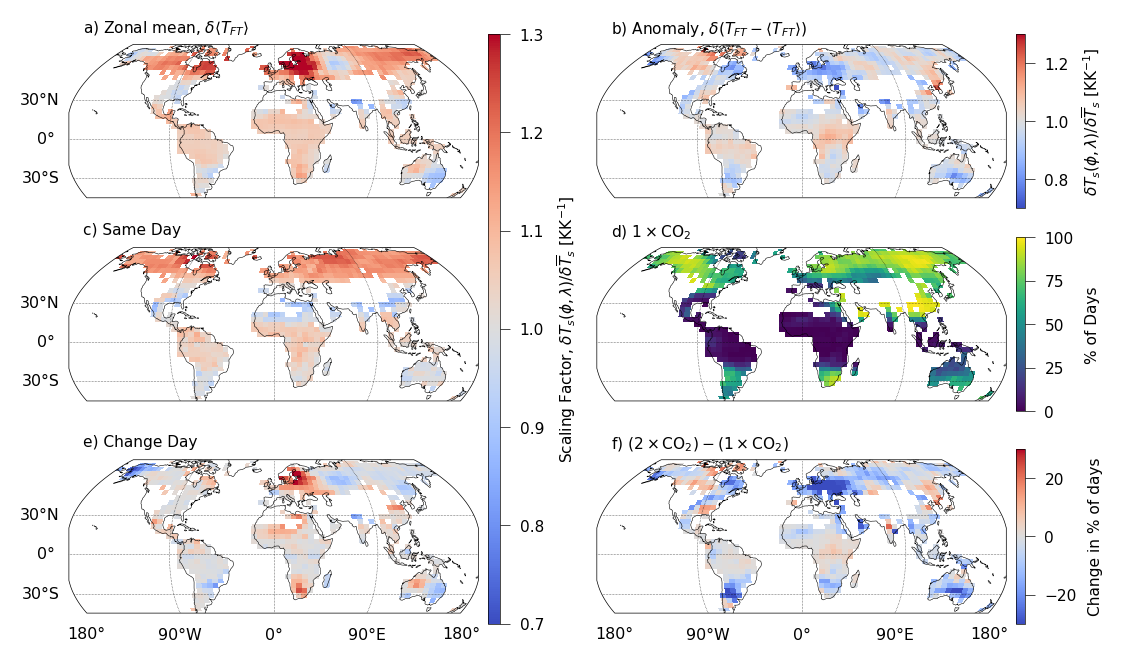

In [48]:
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(3, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
fig_resize(fig, width['two_col'], ar=1.3)
for i in range(len(ax.flatten())):
    gl = utils.initialize_ax_projection(ax.flatten()[i], lat_min=lat_min, lat_max=lat_max, auto_aspect=True,
                                        grid_lat=[-30, 0, 30],
                                        grid_lon=[-180, -90, 0, 90, 180], return_gl=True, gridline_lw=0.2,
                                        coastline_lw=0.2)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    if i < 4:
        gl.bottom_labels = False
    if i % 2:
        gl.left_labels = False


# Zonal Av breakdown
imshow_args_use = {'vmin': 0.7, 'vmax': 1.3,
                   'extent': (0, 360, lat_min, lat_max)}
im = utils.plot_contour_projection(ax[0, 0], temp_ft_zm_sf_cont.where(mask_loc),
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs=imshow_args_use)

var = gamma_ft * (temp_ft_zm_coarse_same_day.diff(dim='co2') - ds_av_global.T_ft_env_zm.diff(dim='co2')).squeeze() + 1
im = utils.plot_contour_projection(ax[1, 0], var.where(mask_loc),
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs=imshow_args_use)
var = gamma_ft * temp_ft_zm_coarse_change_day.diff(dim='co2').squeeze() + 1
im = utils.plot_contour_projection(ax[2, 0], var.where(mask_loc),
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs=imshow_args_use)
plt.colorbar(im, ax=ax[:, 0].ravel(), label=label_sf_spatial, pad=0.02, fraction=0.1, aspect=50)



# Anomaly breakdown
im = utils.plot_contour_projection(ax[0, 1], temp_ft_anom_sf_cont.where(mask_loc),
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs=imshow_args_use)
plt.colorbar(im, ax=ax[0, 1], label=label_sf_spatial.replace('Scaling Factor, ', ''), pad=0.02, fraction=0.1, aspect=20)

imshow_args_use = {'vmin': 0, 'vmax': 100,
                   'extent': (0, 360, lat_min, lat_max)}
im = utils.plot_contour_projection(ax[1, 1], ds_spatial['temp_ft_pos_anom_frac'].isel(co2=0).where(mask_loc),
                                   cmap='viridis', imshow=True,
                                   imshow_kwargs=imshow_args_use)
plt.colorbar(im, ax=ax[1, 1], label='% of Days', pad=0.02, fraction=0.1, aspect=20)
imshow_args_use = {'vmin': -30, 'vmax': 30,
                   'extent': (0, 360, lat_min, lat_max)}
im = utils.plot_contour_projection(ax[2, 1], ds_spatial['temp_ft_pos_anom_frac'].diff(dim='co2').squeeze().where(mask_loc),
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs=imshow_args_use)
plt.colorbar(im, ax=ax[2, 1], label="Change in % of days", pad=0.02, fraction=0.1, aspect=20)


label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=9,
               labels=["a) Zonal mean, $\delta \langle T_{FT}\\rangle$", "b) Anomaly, $\delta \left(T_{FT} - \langle T_{FT}\\rangle\\right)$",
                       "c) Same Day", "d) $1\\times \\text{CO}_2$", "e) Change Day",
                       "f) $(2\\times \\text{CO}_2) - (1\\times \\text{CO}_2)$"])
update_fontsize(fig)

# Correlation between top and bottom above to show can link the two
var = xr.corr(ds_spatial['temp_ft_pos_anom_frac'].diff(dim='co2').squeeze().where(mask_loc), temp_ft_anom_sf_cont.where(mask_loc)-1)
print(f"Correlation of (b) with (f): {var:.2f}")

plt.show()
# savefig(fig)

In [49]:
import cftime

loc_scand = {'lon': slice(5, 40), 'lat': slice(45, 65)}
for i in range(ds_spatial.co2.size):
    var = ds_spatial.mean_doy.isel(co2=i).sel(lon=loc_scand['lon'], lat=loc_scand['lat']).where(mask_loc).median()
    var_date = cftime.num2date(np.round(var) - 1, units="days since 2001-01-01 00:00:00",
    calendar="365_day", only_use_cftime_datetimes=True)
    print(f"Scandanavia av day of year | CO2x{i+1} | {var:.0f} | {var_date}")

Scandanavia av day of year | CO2x1 | 184 | 2001-07-03 00:00:00
Scandanavia av day of year | CO2x2 | 200 | 2001-07-19 00:00:00


### East Canada
Why does East Canada warm so much? Try to explain with solar insolation which is due to change in hour of day when occured.

Need to have run `./scripts/load_ds_quant50_times.py` on JASMIN to get the `ds_quant50.nc` file.

In [50]:
insolation_change = ds_spatial.SOLIN.diff(dim='co2').squeeze()/ds_spatial.SOLIN.isel(co2=0)*100
mask_canada = (ds_sf_spatial.scale_factor>1.9) & mask_loc         # region where sf is largest
print(f"There are {mask_canada.sum():.0f} coordinates where scale factor > 1.9")
# mask_canada = mask_canada & (mask_canada.lon>230) & (mask_canada.lon<320) & (mask_canada.lat>30) & (mask_canada.lat<70)
# ds_canada = ds_canada.where(mask_canada)

There are 25 coordinates where scale factor > 1.9


In [51]:
# Old idea - plot hour of day as a function of quantile using all quant > 50
# Need to have run `./scripts/load_ds_quant50_times.py` with include_temp=True on JASMIN to get the `ds_quant50_canada.nc` file.
show_fig = False
if show_fig:
    ds_canada = xr.open_dataset(os.path.join(utils.out_dir, 'ds_quant50_times_canada.nc')).load()
    time_peak_insolation = (ds_canada.time.dt.hour.isel(co2=0) * 0 + (12 - ds_canada.lon / 15) % 24)
    ds_canada['time_from_midday'] = (ds_canada.time.dt.hour - time_peak_insolation) % 24
    ds_canada = ds_canada.rename_vars({'T': 'TREFHT'})

    # Reindex to match initial dataset
    ds_canada = ds_canada.reindex_like(utils.load_ds('pre_industrial', 95, var_keep=['PS']).isel(sample=0).load())
    # Coarsen to match ds_spatial
    ds_canada = fold_coarsen(ds_canada.sel(lat=slice(lat_min, lat_max)), k_lat=ds_spatial.n_coarse_lat, k_lon=ds_spatial.n_coarse_lon)

    # Normal region to compare to at similar longitudes
    mask_america = (insolation_change<10) & mask_loc
    mask_america = mask_america & (mask_canada.lon>270) & (mask_canada.lon<320) & (mask_canada.lat>35) & (mask_canada.lat<40)

    # Get hour conditioned on each quantile of temp
    quant_vals = np.arange(1, 100)
    mask_use = {'canada': mask_canada, 'america': mask_america}
    time_av = {key: np.zeros((ds_canada.co2.size, quant_vals.size, 3)) for key in mask_use}
    for key in mask_use:
        for i in range(ds_canada.co2.size):
            temp_loc = ds_canada.TREFHT.where(mask_use[key]).isel(co2=i).values.flatten()
            time_loc = ds_canada.time_from_midday.where(mask_use[key]).isel(co2=i).values.flatten()
            time_loc = time_loc[~np.isnan(temp_loc)]
            temp_loc = temp_loc[~np.isnan(temp_loc)]
            for j in range(quant_vals.size):
                ind_use = get_quant_ind(temp_loc, quant_vals[j], 0.5, 0.5)
                time_av[key][i, j] = np.quantile(time_loc[ind_use], [0.25, 0.5, 0.75])

    fig = plt.figure(constrained_layout=True)

    # Make a 2x1 GridSpec so spacing is handled like subplots()
    gs = fig.add_gridspec(2, 1, hspace=0.38, height_ratios=[1, 1])

    ax = [fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())]  # map
    ax.append(fig.add_subplot(gs[1, 0]))                          # normal axes
    fig_resize(fig, width['one_col'], ar=1.5)

    gl = utils.initialize_ax_projection(ax[0], lat_min=lat_min, lat_max=lat_max, auto_aspect=True,
                                        grid_lat=[-30, 0, 30],
                                        grid_lon=[-180, -90, 0, 90, 180], return_gl=True, gridline_lw=0.2,
                                        coastline_lw=0.2)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    contour_lev = np.arange(-60, 60, 20)+10


    plot_scatter_mask(mask_canada, ax[0], s=1, color='k', marker='x', linewidths=0.2)
    plot_scatter_mask(mask_america, ax[0], s=1, color='k', marker='.', linewidths=0.4)
    imshow_args_use = {'vmin': -50, 'vmax': 50,
                       'extent': (0, 360, lat_min, lat_max)}
    im = utils.plot_contour_projection(ax[0], insolation_change,
                                       cmap='coolwarm', imshow=True,
                                       imshow_kwargs=imshow_args_use)
    # im = utils.plot_contour_projection(ax[0], var, mask=mask_loc, levels=contour_lev, cmap='coolwarm')
    plt.colorbar(im, ax=ax[0], label='% Change in Insolation', pad=0.02, fraction=0.013, aspect=30)
    for key in time_av:
        for i in range(ds_spatial.co2.size):
            ax[1].plot(quant_vals, time_av[key][i, :, 1], color=f"C{i}", linestyle=None if key=='canada' else ':',
                       label=utils.co2_labels[i] if key=='canada' else None)
            if key=='canada':
                ax[1].fill_between(quant_vals, time_av[key][i, :, 0], time_av[key][i, :, 2], color=f"C{i}", alpha=0.2, linewidth=0.0)

    pos = ax[1].get_position()                 # Bbox in figure coords [0..1] [web:108]
    dx = 0.1                                # shift right by 3% of figure width
    ax[1].plot(-10, 10, color='k', linestyle=None, label='Canada')
    ax[1].plot(-10, 10, color='k', linestyle=':', label='America')
    update_linewidth(fig)
    ax[1].set_position([pos.x0+dx/3, pos.y0, pos.width+dx/3, pos.height])
    ax[1].legend(handlelength=leg_handlelength, ncol=2, loc='upper right', bbox_to_anchor=(1.05, 1.15), columnspacing=0.8)
    ax[1].set_xlabel(utils.percentile_label)
    ax[1].set_xlim(0, 100)
    ax[1].set_ylim(3, 15)
    ax[1].set_ylabel('Time [hours]')
    label_subplots(fig, [ax[0]], box_alpha=0, pos_y=-1, pos_x=-15)
    label_subplots(fig, [ax[1]], box_alpha=0, pos_y=8, pos_x=-24, labels=['b)'])
    update_fontsize(fig, base_fontsize=8)
    plt.show()
    # savefig(fig)

Correlation of (a) with (b): -0.87


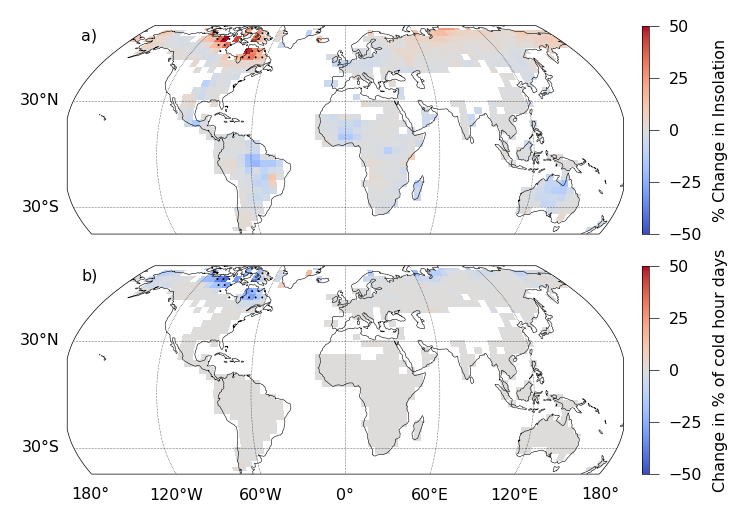

In [52]:
# fig = plt.figure(constrained_layout=True)
# ax = fig.subplots(1, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
# fig_resize(fig, width['two_col'], ar=2.4 * 2)
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
fig_resize(fig, 10, ar=8)
for i, ax_use in enumerate(ax):
    gl = utils.initialize_ax_projection(ax_use, lat_min=lat_min, lat_max=lat_max, grid_lat=[-30, 30], return_gl=True,
                                        coastline_lw=0.2, gridline_lw=0.2)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    if i == 0:
        gl.bottom_labels = False

im = utils.plot_contour_projection(ax[0], insolation_change.where(mask_loc),
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs={'vmin': -50, 'vmax': 50,
                                                  'extent': (0, 360, lat_min, lat_max)})
# ax[0].set_title('% Change in Insolation', fontweight='bold', y=0.95)
im = utils.plot_contour_projection(ax[1], ds_spatial.cold_hour_frac.diff(dim='co2').squeeze().where(mask_loc),
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs={'vmin': -50, 'vmax': 50,
                                                  'extent': (0, 360, lat_min, lat_max)})
# ax[1].set_title('Change in % of cold hour days', fontweight='bold', y=0.95)
    # mask_nl_use = np.abs(ds_sf_spatial_num[f"{var_order[i]}_change"] - 1) > thresh_mask_nl
for ax_use in ax:
    plot_scatter_mask(mask_canada, ax_use, s=2)
# label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=-1, pos_x=-1)
plt.colorbar(im, ax=ax[0], label='% Change in Insolation',
             pad=0.01, aspect=30, ticks=[-50, -25, 0, 25, 50])
plt.colorbar(im, ax=ax[1], label='Change in % of cold hour days',
             pad=0.01, aspect=30, ticks=[-50, -25, 0, 25, 50])
label_subplots(fig, ax, pos_y=-1)
update_fontsize(fig, base_fontsize=5.5)

# Correlation between top and bottom above to show can link the two - only outside tropics as different regime in tropics
var = xr.corr(insolation_change.where(mask_loc & (mask_loc.lat>20)),
              ds_spatial.cold_hour_frac.diff(dim='co2').squeeze().where(mask_loc & (mask_loc.lat>20)))
print(f"Correlation of (a) with (b): {var:.2f}")

plt.show()
# savefig(fig)

In [53]:
for i in range(ds_spatial.co2.size):
    var = ds_spatial.mean_doy.isel(co2=i).where(mask_canada).median()
    var_date = cftime.num2date(np.round(var) - 1, units="days since 2001-01-01 00:00:00",
    calendar="365_day", only_use_cftime_datetimes=True)
    print(f"Canada av day of year | CO2x{i+1} | {var:.0f} | {var_date}")
var = (ds_spatial.QREFHT.diff(dim='co2')/ds_spatial.QREFHT.isel(co2=0)).where(mask_canada).median() * 100
print(f"Canada | % increase in specific humidity = {var:.1f}")

Canada av day of year | CO2x1 | 214 | 2001-08-02 00:00:00
Canada av day of year | CO2x2 | 202 | 2001-07-21 00:00:00
Canada | % increase in specific humidity = 42.1
